In [1]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Connected DB CINS_SMY - conn
Connected oraDW_ANALYTICS - conn_aly


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [3]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.naive_bayes import GaussianNB

In [4]:
from matplotlib.gridspec import GridSpec

# DATA

In [5]:
train_df = pd.read_parquet('/config/workspace/feature-store/reactive_casa/deploy/data/01-07-2023/DATA_LABEL')
valid_df = pd.read_parquet('/config/workspace/feature-store/reactive_casa/deploy/data/01-08-2023/DATA_LABEL')
test_df = pd.read_parquet('/config/workspace/feature-store/reactive_casa/deploy/data/01-11-2023/DATA_LABEL')

In [6]:
x_train, y_train = train_df.drop(columns=['REACTIVATED_CASA']), train_df['REACTIVATED_CASA']
x_valid, y_valid = valid_df.drop(columns=['REACTIVATED_CASA']), valid_df['REACTIVATED_CASA']

In [7]:
num1feat_cols = [
            'CASA_BAL_SUM_LATEST',
            'LOAN_SUM_LATEST',
            'CASA_BAL_SUM_36M',
            'CASA_TXN_AMT_SUM_36M',
            ]
num2feat_cols = [
    'AGE',
    'LOR',
    'CREDIT_SCORE',
    ]

catfeat_cols = ['AREA','PROFESSION','GEN_GRP','LIFE_STG']

# Pipeline + Model
num1_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1)), 
    ('log_tf', FunctionTransformer(func=np.log1p, feature_names_out='one-to-one')), 
    ('scaler', StandardScaler())
])
num2_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    # ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])
transformer = ColumnTransformer(
    transformers=[
        ('num1', num1_transformer, num1feat_cols),
        ('num2', num2_transformer, num2feat_cols),
        ('cat', categorical_transformer, catfeat_cols)]
)

In [8]:
pipeline1 = Pipeline([
        ("transform", transformer),
        ("model", XGBClassifier())
    ])

In [9]:
pipeline2 = Pipeline([
        ("transform", transformer),
        ("model", LogisticRegression())
    ])

In [10]:
pipeline3 = Pipeline([
        ("transform", transformer),
        ("model", RandomForestClassifier(max_depth=10))
    ])

In [11]:
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method='isotonic')
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method='sigmoid')

In [12]:
pipeline4 = Pipeline([
        ("transform", transformer),
        ("model", AdaBoostClassifier())
    ])
pipeline5 = Pipeline([
        ("transform", transformer),
        ("model", MLPClassifier(alpha=1, max_iter=1000))
    ])
pipeline6 = Pipeline([
        ("transform", transformer),
        ("model", DecisionTreeClassifier(max_depth=5))
    ])

# CALIBRATION PLOT

In [21]:
pipeline_list = [
    ('xgboost', pipeline1),
    ('logit', pipeline2),
    ('rf', pipeline3),
    # ('adaboost', pipeline4),
    # ('MLP', pipeline5),
    ('decision-tree', pipeline6),
]

xgboost
logit
rf
decision-tree


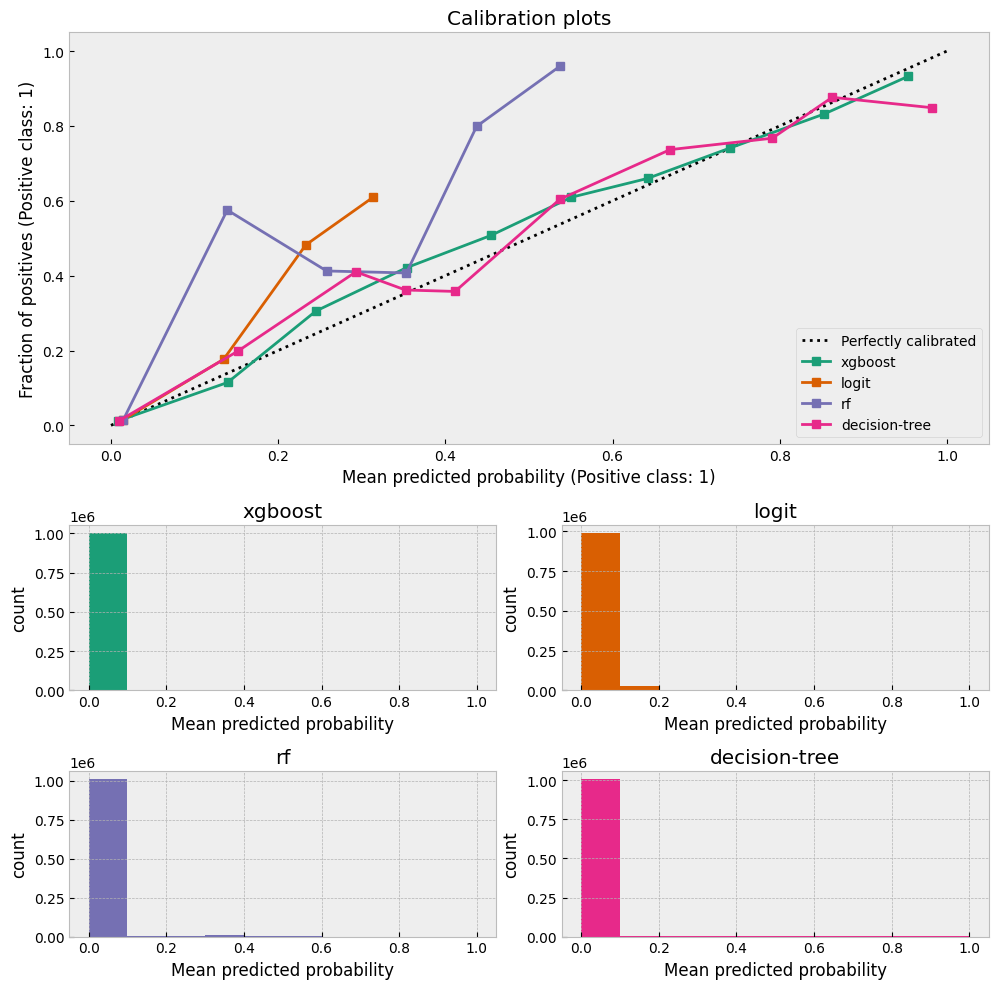

In [30]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4,2)
colors = plt.get_cmap('Dark2')
ax_calibration = fig.add_subplot(gs[:2, :2])
cal_display = {}

result = {}

for i, (name, clf) in enumerate(pipeline_list):
    print(name)
    clf.fit(x_train, y_train)
    y_prob=clf.predict_proba(x_valid)
    y_pred=clf.predict(x_valid)
    result[name] = (y_pred, y_prob)
    display = CalibrationDisplay.from_predictions(y_valid, y_prob[:,1], n_bins=10, name=name, ax=ax_calibration, color=colors(i))
    cal_display[name] = display
ax_calibration.grid()
ax_calibration.set_title('Calibration plots')

g_pos = [(2,0), (2,1), (3,0), (3,1)]
for i, (name, clf) in enumerate(pipeline_list):
    row, col = g_pos[i]
    ax = fig.add_subplot(gs[row, col])
    ax.hist(
        cal_display[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i)
    )
    ax.set(title=name, xlabel='Mean predicted probability', ylabel='count')
plt.tight_layout()
plt.show()

In [15]:
from collections import defaultdict
from sklearn.metrics import brier_score_loss, log_loss, f1_score, precision_score, recall_score, roc_auc_score

In [16]:
scores = defaultdict(list)
for i, (name, clf) in enumerate(pipeline_list):
    y_pred=result[name][0]
    y_prob=result[name][1]
    scores['Classifier'].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__
        scores[score_name].append(metric(y_valid, y_prob[:, 1]))
    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__
        scores[score_name].append(metric(y_valid, y_pred))

    score_df = pd.DataFrame(scores).set_index('Classifier')
    score_df.round(decimals=3)

In [17]:
score_df

,brier_score_loss,log_loss,roc_auc_score,precision_score,recall_score,f1_score
Classifier,,,,,,
xgboost,0.014263,0.069420,0.836418,0.743711,0.349341,0.475382
logit,0.018819,0.089773,0.751981,0.000000,0.000000,0.000000
rf,0.016507,0.076579,0.793999,0.000000,0.000000,0.000000
adaboost,0.226234,0.645572,0.826941,0.731234,0.330226,0.454982
decision-tree,0.014524,0.076493,0.786637,0.730584,0.357863,0.480407


In [18]:

# pipeline_dummy = Pipeline([
#         ("transform", transformer),
#         ("model", DecisionTreeClassifier(max_depth=5))
#     ])

# pipeline_dummy.fit(x_train, y_train)
# y_pred = pipeline_dummy.predict(x_valid)
# y_prob = pipeline_dummy.predict_proba(x_valid)

In [19]:
l = ['01', '02', '03', '04', '05', '06', '07','08', '09','10','11','12']

In [20]:
for i in l:
    print(i)
    df = pd.read_parquet(f'/config/workspace/feature-store/reactive_casa/deploy/data/01-{i}-2023/DATA_LABEL')
    # print(len(df))
    print(df['REACTIVATED_CASA'].value_counts(), df['REACTIVATED_CASA'].value_counts().sum())

01
0    898379
1     13201
Name: REACTIVATED_CASA, dtype: int64 911580
02
0    920735
1      9285
Name: REACTIVATED_CASA, dtype: int64 930020
03
0    942082
1     20632
Name: REACTIVATED_CASA, dtype: int64 962714
04
0    963443
1     22227
Name: REACTIVATED_CASA, dtype: int64 985670
05
0    986695
1     24098
Name: REACTIVATED_CASA, dtype: int64 1010793
06
0    988098
1     46527
Name: REACTIVATED_CASA, dtype: int64 1034625
07
0    997687
1     19045
Name: REACTIVATED_CASA, dtype: int64 1016732
08
0    1002951
1      21240
Name: REACTIVATED_CASA, dtype: int64 1024191
09
0    1018359
1      22593
Name: REACTIVATED_CASA, dtype: int64 1040952
10
0    1026635
1      29869
Name: REACTIVATED_CASA, dtype: int64 1056504
11
0    1001492
1      74182
Name: REACTIVATED_CASA, dtype: int64 1075674
12
0    1022429
1      18766
Name: REACTIVATED_CASA, dtype: int64 1041195
